In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tkinter as tk
from PIL import Image, ImageDraw
from tqdm import tqdm


graphics_path = r'C:\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\acc_graphics'

# Cargar el archivo CSV
df = pd.read_csv(r"C:\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\datasets\fashion-mnist_train.csv")


data = np.array(df)

np.random.seed(0)

muestras, columnas = data.shape
print(muestras, columnas)

np.random.shuffle(data) # mezclo para evitar overffitting



data_test = data[50000:, :].T # hago que cada uestra sea una columna y no una fila como antes
Y_test = data_test [0]
X_test = data_test [1:]
mean = np.mean(X_test)
std_dev = np.std(X_test)

# Normalizar usando desviación estándar
X_test = (X_test - mean) / std_dev
# X_test = X_test / 255.

data_train = data[:50000].T # hago que cada muestra sea una columna y no una fila como antes
Y_train = data_train[0] # la col 0 es el label
X_train = data_train[1:]
mean = np.mean(X_train)
std_dev = np.std(X_train)

print(X_test.shape)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)

60000 785
(784, 10000)
(10000,)
(784, 50000)
(50000,)


  0%|          | 0/20000 [00:00<?, ?it/s]C:\Users\Martin\AppData\Local\Temp\ipykernel_8084\2470627545.py:29: RuntimeWarning: invalid value encountered in divide
  return exp_Z / exp_Z.sum(axis=0)
100%|██████████| 20000/20000 [02:10<00:00, 153.00it/s]


test: 0.114  train : 0.108


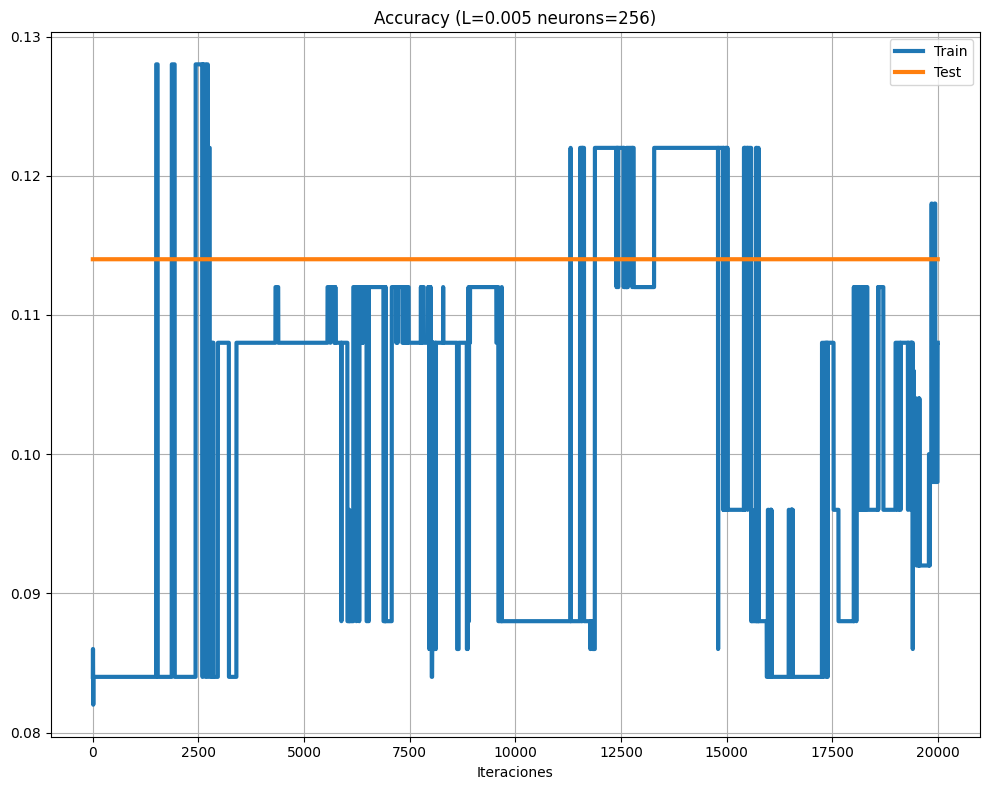

In [7]:
class NeuralNetwork:
    def __init__(self, neurons, learning_rate, iterations):
        self.neurons = neurons
        self.learning_rate = learning_rate
        self.iterations = iterations
        
        # Inicializar pesos y sesgos
        self.w_hidden = np.random.rand(self.neurons, 784) - 0.5
        self.w_output = np.random.rand(10, self.neurons) - 0.5
        self.b_hidden = np.random.rand(self.neurons, 1) - 0.5
        self.b_output = np.random.rand(10, 1) - 0.5

        self.accuracy_train_l = []
        self.accuracy_test_l = []
        
        subset_size = 500
        
        self.X_train_subset = X_train[:, 0:subset_size]
        self.Y_train_subset = Y_train[0:subset_size]
        self.X_test_subset = X_test[:, 0:subset_size]
        self.Y_test_subset = Y_test[0:subset_size]

    # Funciones de activación
    def relu(self, x):
        return np.maximum(x, 0)

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z))
        return exp_Z / exp_Z.sum(axis=0)

    def forward_prop(self, X):
        Z1 = self.w_hidden @ X + self.b_hidden
        A1 = self.relu(Z1)
        Z2 = self.w_output @ A1 + self.b_output
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2

    def one_hot_encode(self, Y):
        one_hot_Y = np.zeros((10, Y.shape[0]))
        one_hot_Y[Y] = 1
        return one_hot_Y

    def d_relu(self, x):
        return x > 0

    def backward_prop(self, Z1, A1, Z2, A2, X, Y):
        one_hot_Y = self.one_hot_encode(Y)
        dZ2 = A2 - one_hot_Y
        
        
        dC_dW2 = dZ2.dot(A1.T)
        dC_dB2 = np.sum(dZ2, axis=1, keepdims=True)
        
        dZ1 = self.w_output.T.dot(dZ2) * self.d_relu(Z1)
        
        dC_dW1 = dZ1.dot(X.T)
        dC_dB1 = np.sum(dZ1, axis=1, keepdims=True)
        return dC_dW1, dC_dB1, dC_dW2, dC_dB2

    def train(self, X_train, Y_train, X_test, Y_test):
        for i in tqdm(range(self.iterations)):
            # seleccionar aleatoriamente uno de los datos de entrenamiento
            idx = np.random.choice(X_train.shape[1], 1, replace=False)
            X_sample = X_train[:, idx]
            Y_sample = Y_train[idx]

            # pasar datos seleccionados aleatoriamente a través de la red neuronal
            Z1, A1, Z2, A2 = self.forward_prop(X_sample)

            # distribuir error a través de la retropropagación
            dW1, dB1, dW2, dB2 = self.backward_prop(Z1, A1, Z2, A2, X_sample, Y_sample)

            # actualizar pesos y sesgos
            self.w_hidden -= self.learning_rate * dW1
            self.b_hidden -= self.learning_rate * dB1
            self.w_output -= self.learning_rate * dW2
            self.b_output -= self.learning_rate * dB2
            

            # Calcular precisión del conjunto de prueba
            test_predictions = self.forward_prop(self.X_test_subset)[3]
            test_comparisons = np.argmax(test_predictions, axis=0) == self.Y_test_subset
            accuracy_test = np.mean(test_comparisons)
            self.accuracy_test_l.append(accuracy_test)
                
            # Calcular precisión del conjunto de entrenamiento
            train_predictions = self.forward_prop(self.X_train_subset)[3]
            train_comparisons = np.argmax(train_predictions, axis=0) == self.Y_train_subset
            accuracy_train = np.mean(train_comparisons)
            self.accuracy_train_l.append(accuracy_train)

                # Imprimir la pérdida y la precisión
            loss = np.mean((A2 - self.one_hot_encode(Y_sample)) ** 2)  # Pérdida cuadrática media
                
        print(F"test: {accuracy_test}  train : {accuracy_train}")
        self.accuracy_graphic(self.learning_rate, self.accuracy_train_l, self.accuracy_test_l, self.neurons)

    def accuracy_graphic(self, L, train_l, test_l, neurons):
        iters = self.iterations
        fmt_train = {
            'color': 'tab:blue',
            'ls': 'solid',
            'lw': 3,
        }
        fmt_test = {
            'color': 'tab:orange',
            'ls': 'solid',
            'lw': 3,
        }

        fig, (ax) = plt.subplots(1, 1, figsize=(10, 8))
        ax.plot(train_l, label='Train', **fmt_train)
        ax.plot(test_l, label='Test', **fmt_test)

        ax.grid(which='both')
        ax.legend()
        ax.set_title(f'Accuracy ({L=} {neurons=})')
        ax.set_xlabel('Iteraciones')

        fig.tight_layout()
        plt.savefig( os.path.join(graphics_path, f"accuracy_{L=}_{iters=}_{neurons=}.png"))
        plt.show()


# Ejemplo de uso
iters = 20_000
L = 0.005
neurons = 256


nn = NeuralNetwork(neurons, L, iters)
nn.train(X_train, Y_train, X_test, Y_test)

In [ ]:
# This function generates predictions using the input data and the trained parameters.
def get_predictions(A2):
    return np.argmax(A2, axis=0)

def make_predictions(X):
    _, _, _, A2 = nn.forward_prop(X)
    predictions = get_predictions(A2)
    return predictions

# Función para procesar una imagen
def procesar_imagen(ruta_imagen):
    # Cargar la imagen
    img = Image.open(ruta_imagen)
    
    # Convertir a escala de grises
    img = img.convert('L')
    
    # Redimensionar a 28x28 píxeles
    img = img.resize((28, 28))
    
    # Convertir la imagen a un array numpy
    img_array = np.array(img)
    
    # Invierte los colores restandle el valor original a 255 y se lo asigna osea si es blanco (255) y se lo restas a 255 entonces te queda negro
    # img_array = 255 - img_array
    
    # Escalar los valores de los píxeles entre 0 y 1
    img_array = img_array / 255.0
    
    # Aplanar la imagen para que sea un vector de 784 dimensiones (28x28)
    img_array = img_array.flatten()
    
    # Convertir a formato adecuado para el modelo (1 imagen)
    return img_array.reshape(1, -1)

# Función para mostrar la imagen junto con su predicción
def mostrar_imagen_con_prediccion(img_array, prediccion):
    # Convertir el array plano de 784 de vuelta a una matriz 28x28
    img_reshaped = img_array.reshape(28, 28)
    
    # Mostrar la imagen usando matplotlib
    plt.title(f'Predicción: {prediccion}')
    plt.imshow(img_reshaped, cmap='gray')
    plt.show()

# Ruta de la carpeta con las imágenes
carpeta_imagenes = r'\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\assets_mnist'

# Obtener una lista de todos los archivos en la carpeta
imagenes = [f for f in os.listdir(carpeta_imagenes) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Recorrer cada imagen en la carpeta
for imagen_nombre in imagenes:
    ruta_imagen = os.path.join(carpeta_imagenes, imagen_nombre)
    
    # Procesar la imagen
    imagen_procesada = procesar_imagen(ruta_imagen)
    
    # Realizar la predicción con el modelo entrenado
    prediccion = make_predictions(imagen_procesada.T)
    
    # Mostrar la imagen con su predicción
    mostrar_imagen_con_prediccion(imagen_procesada, prediccion[0])